# Data Visualization of the Global Historical Climatology Network-Daily Database

## Introducing the data

**What is the GHCN?**

As you can read from [NOAA website](https://www.ncdc.noaa.gov/data-access/land-based-station-data/land-based-datasets/global-historical-climatology-network-ghcn):

>The Global Historical Climatology Network (GHCN) is an integrated database of climate summaries from land surface stations across the globe that have been subjected to a common suite of quality assurance reviews. The data are obtained from more than 20 sources. Some data are more than 175 years old while others are less than an hour old.

**The data**

You can download all the GHCN data from [here](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/).

For this project, we took the archive 'ghcnd_all.tar.gz'. As the name suggests, this archive contains all the data from the GHCN-Daily Database. Among many other files, it includes:
- a more than usefull readme.txt describing all the others files, including their columns widths (required for Pandas to read them)
- a fixed width file describing *108081* weather stations.
- a fixed width file containing the daily measures for each stations. In these 108081 files, each line represents a month of measures. The oldest measures are minimum and maximum temperatures from *January 1763* and there are up to *137* different types of measures!!! But not all of the 108081 stations have been working since 1763 and not all of them record 137 items. There are actually only 5 core elements measured:
  - PRCP: Precipitation in tenths of mm
  - SNOW: Snowfall in mm
  - SNWD: Snowdepth in mm
  - TMAX: Maximum temperature in tenths of degrees
  - TMIN: Minimum temperature in tenths of degrees

Still, at the time of this project, the daily files contain all together 103,440,334 lines, **roughly 3,206,650,354 measures!!**

## Strategy

I thought the best way to visualize such a big amount a data was to make a video of one or two element(s) (e.g. TMAX and/or PRCP) measured through time, plotted on a world map. As we will see, some places have a high density of weather stations wich is impossible to show as individual measures on a big scale. On the other hand, most of the globe has no station at all. This is a chance to geographically aggregate the data to decrease the number of points to display. Since I wanted to keep a good mapping resolution, I decided to aggregate the data in 2500 km² units called 'sectors'.

The second element to consider were the tools to store, process and plot the measures. My choice was to store all the data in a single SQLite database and to request, aggregate and plot the measures using respectively SQL queries, Pandas Dataframes and Matplotlib/Cartopy.

At last, I used [ffmpeg](https://www.ffmpeg.org/) to turn all the plots into a video.

## Building the sectors to aggregate the data

Though it is very likely that an existing algorithm is readily available for such a task, I decided to write my own simple piece of code to split the globe into 2500 km² units. It is a mathematical approximation based on a perfectly spherical Earth. Despite beeing wrong, it is very simple and the result is only 0.4% off compared to the actual Earth surface area. Take a look [here](http://www.longitudestore.com/how-big-is-one-gps-degree.html) for more explanations.

At the end of the algorithm, we have a list of 204823 sectors described by an id, the latitude and longitude of their 4 corners and their central point - wich will be used as x and y to plot the data. There are many more sectors than stations but most of them are in ocean (70% of the globe surface) where there are no stations and - once again - most of the lands have no station at all. Therefore, we will only need a small fraction of them.

In [2]:
from math import pi, cos, ceil
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#Earth radius and perimeter and unit size (50km*50km=2500km²)
Pe=40075
Re=Pe/(2*pi)
unit_size=50

n_lat=ceil((Pe/2)/unit_size) #number of units per degree of latitude
i_lat = 180/n_lat #unit size in degrees of latitude

def count_lon(lat): #function to compute the number of units per degree of longitude according to the latitude
    return(ceil((Re*cos(pi*lat/180)*2*pi)/unit_size))

#initializing before the loop: empty sector list, start of the loop at -90° of latitude and i=j=0 
#are the counters for latitude and longitude
sector_list=[]
lat_min = -90
i=0

while i<n_lat:
    lat_max=lat_min+i_lat
    lon_min=-180
    n_lon=count_lon(lat_min)
    i_lon=360/n_lon
    j=0
    
    while j < n_lon:
        lon_max=lon_min+i_lon
        lat_cen=lat_min+i_lat/2
        lon_cen=lon_min+i_lon/2
        sector_list.append([lat_min,lat_max,lon_min,lon_max,lat_cen,lon_cen])
        lon_min+=i_lon
        j+=1
    
    lat_min=lat_min+i_lat
    i+=1
    
sectors_df=pd.DataFrame(sector_list,columns=['lat_min','lat_max','lon_min','lon_max','lat_cen','lon_cen'])
sectors_df.shape

(204823, 6)

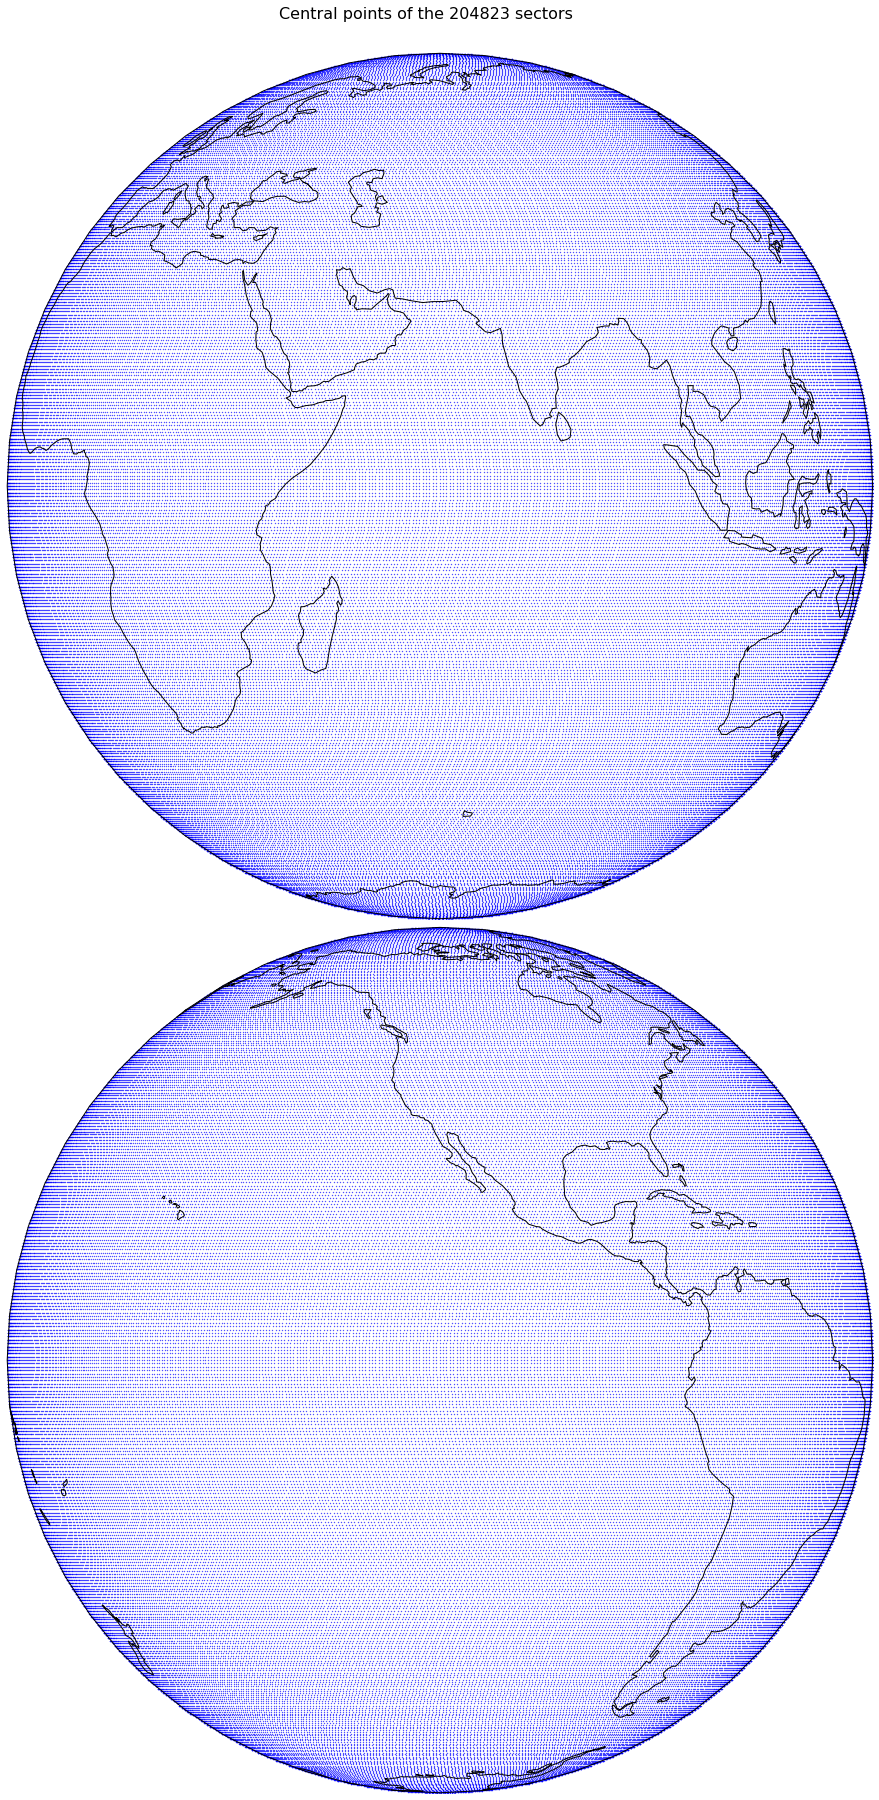

In [3]:
#creating the figure and geoaxes
fig_map=plt.figure(figsize=(16,32))
fig_map.suptitle('Central points of the 204823 sectors',fontsize=16,y=0.9)
gs=fig_map.add_gridspec(nrows=2,ncols=1,wspace=0.05,hspace=0.01)

ax_map1=fig_map.add_subplot(gs[0,0],projection=ccrs.Orthographic(central_longitude=64))
ax_map1.coastlines()
ax_map1.set_global()

ax_map2=fig_map.add_subplot(gs[1,0],projection=ccrs.Orthographic(central_longitude=64+180))
ax_map2.coastlines()
ax_map2.set_global()

on_face1=(sectors_df['lon_cen'].between(64-90,64+90))

x_face1=sectors_df.loc[on_face1,'lon_cen']
y_face1=sectors_df.loc[on_face1,'lat_cen']
x_face2=sectors_df.loc[~on_face1,'lon_cen']
y_face2=sectors_df.loc[~on_face1,'lat_cen']

ax_map1.scatter(x_face1,y_face1,s=0.1,c='blue',alpha=1,transform=ccrs.PlateCarree())

ax_map2.scatter(x_face2,y_face2,s=0.1,c='blue',alpha=1,transform=ccrs.PlateCarree())
plt.show()

## Building the database

Using Python Sqlite3 module, I built the following database:

![DB_diagram.png](DB_diagram.png)

We already know the sectors. The stations are imported from the fixed width file 'ghcnd-stations.txt'. While the file includes a few more features to describre the stations, we are only interested in their latitude and longitude that we will use to aggregate their measures.

The measures were gathered from the 108081 station files into a single table wich is more convenient to handle. As said before, each line represents a full month of measure for one item. That's why we have the following composite primary key: 'id-year-month-element'. The value for each day is stored in a column 'valueX', X being the day number. For months with less than 31 days, the value is -9999 wich is also the value for missing data.

## Stations over space and time

*(All the following figures were created by querying the database and plotting the data with Matplotlib/Cartopy)*

As we saw, 108,081 stations are listed in the Global Historical Climatology Network-Daily database. But the actual number of stations working at the same time has been widely varying over time (see figure below). In fact, never more than 41,324 stations around the world have been active at the same time.

![stations_number_over_time.png](attached:stations_number_over_time.png)

In addition, the geographical distribution of the stations is really uneven: most of them are or have been in the United-States (55%), Australia (16%), Canada (8%), Brazil (5.5%) and India (3.5%). 

![stations_per_country.png](stations_per_country.png)

Let's use our sectors to see how the geographical density of the stations evolve over time:

![1950_stations_density.png](1950_stations_density.png)
![1967_stations_density.png](1967_stations_density.png)
![1984_stations_density.png](1984_stations_density.png)
![2001_stations_density.png](2001_stations_density.png)
![2018_stations_density.png](2018_stations_density.png)

Theses maps reveal clearly that since 1950, the stations have been disappearing from India, Brazil and South Africa while remaining constant in density in the US, Australia, Germany and Sweden.

## Example of Python script to make a data visualization video 

The following example is a script callable from shell to make a video of one item between two dates:

In [13]:
#command shoulb like : python dataviz.py [start date][end date][element][norm][vmin][vmax][colormap]
#Example1 : python dataviz.py 1998-01-01 2018-12-31 PRCP log 1 20000 PuBuGn
#Example2 : python dataviz.py 1998-01-01 2018-12-31 TMAX norm -500 500 coolwarm

'''
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import sys

#taking inputs from script arguments
i=0
start_date=sys.argv[1]
end_date=sys.argv[2]
dates=pd.date_range(start_date,end_date)
elt=sys.argv[3]
norm=sys.argv[4]
min_value=sys.argv[5]
max_value=sys.argv[6]
if norm=='norm':
    norm=colors.Normalize(vmin=min_value,vmax=max_value)
elif norm=='log':
    norm=colors.LogNorm(vmin=min_value,vmax=max_value)
colormap=sys.argv[7]

#connecting to database and iterating days from start_date to end_date
with sqlite3.connect('data.db') as conn:
    for date in dates:
    
        #reading data into a Pandas Dataframe
        value='value{}'.format(date.day)
        data=pd.read_sql_query('
            SELECT {},sectors.sector_id,lat_cen,lon_cen
            FROM measures
            LEFT JOIN stations ON measures.id = stations.id
            LEFT JOIN sectors ON stations.sector_id = sectors.sector_id
            WHERE element='{}' AND year={} AND month={}
            '.format(value,elt,date.year,date.month),conn)
                
        #splitting data on missing/not missing and aggregating by sector_id
        missing_data=data.loc[data[value]==-9999]
        data=data.loc[~(data[value]==-9999)]
        missing_data_agg=missing_data.groupby('sector_id').agg('first')
        data_agg=data.groupby('sector_id').agg({value:np.median,'lat_cen':'first','lon_cen':'first'})
        
        #preparing figure and GeoAxe
        fig_map=plt.figure(figsize=(16.53,11.59))
        ax_map=fig_map.add_subplot(1,1,1,projection=ccrs.PlateCarree())
        ax_map.set_global()
        ax_map.add_feature(cfeature.OCEAN)
        ax_map.set_title('{}-{}-{}-{}'.format(elt,date.year,date.month,value))

        #plotting missing data
        x=missing_data_agg['lon_cen']
        y=missing_data_agg['lat_cen']

        ax_map.scatter(x,y,s=0.1,c='silver',alpha=1,label='missing data'
                      ,transform=ccrs.PlateCarree())

        #plotting data
        x=data_agg['lon_cen']
        y=data_agg['lat_cen']
        c=data_agg[value]

        axs=ax_map.scatter(x,y,s=0.5,c=c,alpha=1,norm=norm,cmap=colormap,
                           transform=ccrs.PlateCarree())
        
        #making frame for the video and displaying progress of the script
        fig_map.colorbar(axs,orientation='horizontal',fraction=0.1,pad=0,aspect=70)
        fig_map.savefig('{}{:04d}.png'.format(elt,i),format='png',dpi=150,papertype='a3',facecolor='darkgrey')
        os.system('mogrify -crop 1926x1065+308+413 {}{:04d}.png'.format(elt,i))
        os.system('echo -n {0:.2f}%\r'.format((i/len(dates))*100))

        plt.close()
        i+=1

os.system('ffmpeg -framerate 8 -i {}%04d.png -r 24 {}_{}_{}.mp4'.format(elt,elt,start_date,end_date))
os.system('rm {}*.png'.format(elt))
'''

"\nimport sqlite3\nimport pandas as pd\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport matplotlib.colors as colors\nimport cartopy.crs as ccrs\nimport cartopy.feature as cfeature\nimport os\nimport sys\n\n#taking inputs from script arguments\ni=0\nstart_date=sys.argv[1]\nend_date=sys.argv[2]\ndates=pd.date_range(start_date,end_date)\nelt=sys.argv[3]\nnorm=sys.argv[4]\nmin_value=sys.argv[5]\nmax_value=sys.argv[6]\nif norm=='norm':\n    norm=colors.Normalize(vmin=min_value,vmax=max_value)\nelif norm=='log':\n    norm=colors.LogNorm(vmin=min_value,vmax=max_value)\ncolormap=sys.argv[7]\n\n#connecting to database and iterating days from start_date to end_date\nwith sqlite3.connect('data.db') as conn:\n    for date in dates:\n    \n        #reading data into a Pandas Dataframe\n        value='value{}'.format(date.day)\n        data=pd.read_sql_query('\n            SELECT {},sectors.sector_id,lat_cen,lon_cen\n            FROM measures\n            LEFT JOIN stations ON measures.i

## "50 Years of US Climate" Video

From the previous work emerged the idea of making a deeper visualization video, with more elements shown on a longer period of time. I also found interesting to add a plot to display and follow the trend for each element and, why not, reveal a possible pattern (global warming - not to mention it). I considered 50 years to be a good duration since it is significant but not too long to turn into a video: with one frame per day at 24 frames per second, the expected video duration is around 13 minutes.

50 years is also a good duration since 50 years ago, the number of active GHCN stations was about 75% of what it is now, wich is enough to map data without too many holes. And since most of those stations are located in the United-States, I decided to focus only on this country. Once again, the idea is to make a very signifcant video.

To avoid bias in the data, I had to only select stations wich were active from the first to the last day of data visualization. Indeed, the appearance or disappearance of stations during the studied period could influence the data depending on their number and location. For example, if, from 1958 to 2018, 150 stations in Arizona stopped their activity and were replaced by 150 stations in Alaska, we would certainly observe a slight decrease in average temperature.

Picking the stations that remained active during the 50 years required the addition of a new table to the database: "invetory". This table was built from a file - "GHCND-inventory.txt" -I didn't need for previous works but wich was already included in the archive anyway. This file lists for each station all the elements recorded along with the first and last years of measure. Here is the new database diagram:

![DB_diagram2.png](DB_diagram2.png)

After a lot of work with the Python script, I am quite happy with the outcome which clearly shows the significant and durable increase in the minimal temperature as you can see from the last frame of the video:

![US_climate18627.png](US_climate18627.png)

If you wish to work yourself with the processed data, you will find in this Git-Hub repository, three csv files:
- ***dly_stats.csv*** contains the daily sum of SNOW and PRCP and daily mean of TMIN and TMAX of all the US stations from 1958-01-01 to 2018-12-31.
- ***period_stats.csv*** contains the past 30 days sum of SNOW and PRCP and past 30 days mean of TMIN and TMAX of all the US stations from 1958-02-01 to 2018-12-31.
- ***period2_stats.csv*** contains the past 365 days sum of SNOW and PRCP and past 365 days mean of TMIN and TMAX of all the US stations from 1959-01-01 to 2018-12-31.

And, at least, here is the Python script behind the video:

In [ ]:
'''
#!/usr/local/bin/python3.7
# -*-coding:Utf-8 -*

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import sys
import datetime
from math import ceil

#setting all variables
i=0
start_date=pd.to_datetime('1968-01-01')
end_date=pd.to_datetime('2018-01-01')
dates=pd.date_range(start_date,end_date)
period=datetime.timedelta(days=30)
period2=datetime.timedelta(days=365)

#Dic of items to map and plot. vmins and vmaxs taken from https://en.wikipedia.org/wiki/List_of_weather_records
items={1:{'name':'TMIN','norm':colors.Normalize(vmin=-622,vmax=622),'cmap':'coolwarm','gsx':0,'gsy':0,
         'des':'Daily minimal temperature in tenths of degree'},
       2:{'name':'TMAX','norm':colors.Normalize(vmin=-622,vmax=622),'cmap':'coolwarm','gsx':1,'gsy':0,
         'des':'Daily maximal temperature in tenths of degree'},
       3:{'name':'PRCP','norm':colors.LogNorm(vmin=1,vmax=18000),'cmap':'YlGnBu','gsx':0,'gsy':1,
         'des':'Daily precipitation in tenths of millimeter'},
       4:{'name':'SNOW','norm':colors.LogNorm(vmin=1,vmax=2560),'cmap':'PuBuGn','gsx':1,'gsy':1,
         'des':'Daily snwofall in millimeter'}
      }

element_list=[]
for key in items:
    element_list.append(items[key]['name'])
    
#connection to database
with sqlite3.connect('data.db') as conn:
    
    #dictionary of stations that were active from start_date to end_date for each element
    stations={}
    for key in items:
        stations[key]=pd.read_sql_query('
        SELECT id FROM inventory WHERE id like 'US%' AND first_year<={} AND last_year>={} AND element='{}';
        '.format(start_date.year,end_date.year,items[key]['name']),conn)
    
    #dataframe to store daily measures and period/period2 stats
    dly_stats=pd.DataFrame(index=dates,columns=element_list)
    period_stats=pd.DataFrame(index=dates,columns=element_list)
    period_stats['line1']=1
    period_stats['line2']=2
    period_stats['line3']=3
    period2_stats=pd.DataFrame(index=dates,columns=element_list)

    #iterating days from start_date to end_date, from now on, each iteration will be a frame of the video
    for date in dates:
        value='value{}'.format(date.day)
    
        #reading measures for the day into a Pandas Dataframe
        data=pd.read_sql_query('
            SELECT measures.id,element,{},sectors.sector_id,lat_cen,lon_cen
            FROM measures
            LEFT JOIN stations ON measures.id = stations.id
            LEFT JOIN sectors ON stations.sector_id = sectors.sector_id
            WHERE element IN ({}) AND year={} AND month={} AND stations.id like 'US%'
            '.format(value,str(element_list)[1:-1],date.year,date.month),conn) 
        
        #plotting the data
        
        #1) Figure creation
        fig_map=plt.figure(figsize=(16.53,9.30))
        fig_map.suptitle('US CLIMATE FROM {} TO {} : {}-{}-{}'.format(start_date.year,end_date.year,date.year,date.month,date.day),
                         fontsize=12,y=0.92,ha='center')
        gs=fig_map.add_gridspec(nrows=5,ncols=2,hspace=0.08,wspace=0.08)
        
        ax_plot=fig_map.add_subplot(gs[4,:])
        ax_plot.text('1967-10-15',3.25,'TMIN',backgroundcolor='darkgrey',fontsize=8,color='royalblue',ha='right',va='center')
        ax_plot.text('1967-10-15',4.25,'TMAX',backgroundcolor='darkgrey',fontsize=8,color='crimson',ha='right',va='center')
        ax_plot.text('1967-10-15',2,'PRCP',backgroundcolor='darkgrey',fontsize=8,color='darkcyan',ha='right',va='center')
        ax_plot.text('1967-10-15',1,'SNOW',backgroundcolor='darkgrey',fontsize=8,color='deepskyblue',ha='right',va='center')
        
        interval=datetime.timedelta(days=400)
        texts={1:{'y':3.25,'text':'TMIN is Minimal Temperature\n(Upper Left Map).','color':'royalblue'},
               2:{'y':4.25,'text':'TMAX is Maximal Temperature\n(Upper Right Map).','color':'crimson'},
               3:{'y':2,'text':'PRCP is precipitation\n(Lower Left Map).','color':'darkcyan'},
               4:{'y':1,'text':'SNOW is snowfall\n(Lower Right Map).','color':'deepskyblue'},
               5:{'y':3,'text':'Horizontal light grey lines are \n1968 reference level for each item.','color':'grey'},
               6:{'y':3,'text':'Lighter colored lines are\neither mean or sum for\nthe past 30 days.',
                  'color':'lightcoral'},
               7:{'y':3,'text':'Darker colored lines are\neither mean or sum for\nthe past 365 days.',
                  'color':'crimson'}
              }
        if start_date<date<=(start_date+len(texts)*interval):
            n=ceil((date-start_date)/interval)
            ax_plot.text(x=start_date+n*interval,y=texts[n]['y'],s=texts[n]['text'],color=texts[n]['color'],
                         fontsize=8,ha='left',va='center',backgroundcolor='white')

        #2) Iterating through items
        measures={}
        ax_map={}
        axs={}
        ref_stats={}
        
        for key in items:
            item=items[key]
            
            #3) Only keep measures from the stations that were active from start_date to end_date
            element=item['name']
            measures[key]=data[(data['id'].isin(stations[key]['id']))&
                               (data['element']==element)&
                               (data[value]>-999)] #missing data is actually -9999 but -999 was also found
            
            #4) Aggregation by sectors and stats computation
            measures[key]=measures[key].groupby('sector_id').agg({value:np.median,'lat_cen':'first','lon_cen':'first'})
            if item['name'] in ['PRCP','SNOW']:
                dly_stats.loc[date,item['name']]=measures[key][value].sum()
            else:
                dly_stats.loc[date,item['name']]=measures[key][value].mean()
            
            #5) Axe creation
            ax_map[key]=fig_map.add_subplot(gs[2*item['gsy']:2*item['gsy']+2,item['gsx']],projection=ccrs.PlateCarree())
            ax_map[key].set_extent((-168,-58,24,72),ccrs.PlateCarree())
            ax_map[key].add_feature(cfeature.OCEAN)
            ax_map[key].coastlines()
            ax_map[key].set_title('{}'.format(item['des']),fontsize=8)
            
            #6) Plotting on the maps
            x=measures[key]['lon_cen']
            y=measures[key]['lat_cen']
            c=measures[key][value]
            axs[key]=ax_map[key].scatter(x,y,s=1,c=c,alpha=1,norm=item['norm'],cmap=item['cmap'],
                                    transform=ccrs.PlateCarree())
            fig_map.colorbar(axs[key],orientation='vertical',fraction=0.0122,pad=0,aspect=35)
            
            #7) Plotting period stats - TMIN,TMAX and PRCP are tweaked to be conveniently located on the plot
            if date-start_date>=period:
                period_date=date-period
                if item['name']=='SNOW':
                    ref=dly_stats.loc[start_date:start_date+period,item['name']].sum()
                    period_stats.loc[date,item['name']]=(dly_stats.loc[period_date:date,item['name']].sum())/ref
                elif item['name']=='PRCP':
                    ref=dly_stats.loc[start_date:start_date+period,item['name']].sum()
                    period_stats.loc[date,item['name']]=((dly_stats.loc[period_date:date,item['name']].sum())/ref)+1
                elif item['name']=='TMAX':
                    ref=dly_stats.loc[start_date:start_date+period,item['name']].mean()
                    period_stats.loc[date,item['name']]=((dly_stats.loc[period_date:date,item['name']].mean())/ref)/3+(8/3)
                elif item['name']=='TMIN':
                    ref=dly_stats.loc[start_date:start_date+period,item['name']].mean()
                    period_stats.loc[date,item['name']]=((dly_stats.loc[period_date:date,item['name']].mean())/ref)/-3+(10/3)
                    
            if date-start_date>=period2:
                period2_date=date-period2
                if item['name']=='SNOW':
                    ref2=dly_stats.loc[start_date:start_date+period2,item['name']].sum()
                    period2_stats.loc[date,item['name']]=(dly_stats.loc[period2_date:date,item['name']].sum())/ref2
                elif item['name']=='PRCP':
                    ref2=dly_stats.loc[start_date:start_date+period2,item['name']].sum()
                    period2_stats.loc[date,item['name']]=((dly_stats.loc[period2_date:date,item['name']].sum())/ref2)+1
                elif item['name']=='TMAX':
                    ref2=dly_stats.loc[start_date:start_date+period2,item['name']].mean()
                    period2_stats.loc[date,item['name']]=((dly_stats.loc[period2_date:date,item['name']].mean())/ref2)+2
                elif item['name']=='TMIN':
                    ref2=dly_stats.loc[start_date:start_date+period2,item['name']].mean()
                    period2_stats.loc[date,item['name']]=((dly_stats.loc[period2_date:date,item['name']].mean())/ref2)+2
                                
        period_stats.plot(ax=ax_plot,xlim=(start_date,end_date),ylim=(-0.2,5.2),legend=False,linewidth=1,yticks=[],
                          color=['lightsteelblue','lightcoral','paleturquoise','skyblue','lightgrey','lightgrey','lightgrey'])
        period2_stats.plot(ax=ax_plot,xlim=(start_date,end_date),ylim=(-0.2,5.2),legend=False,linewidth=1,yticks=[],
                          color=['royalblue','red','darkcyan','deepskyblue'])
        
        #making frame for the video and displaying progress of the script        
        fig_map.savefig('US_climate{:04d}.png'.format(i),format='png',dpi=150,papertype='a3',facecolor='darkgrey')
        os.system('mogrify -crop 2096x1180+224+100 US_climate{:04d}.png'.format(i))
        os.system('echo -n {0:.2f}%\r'.format((i/len(dates))*100))

        plt.close()
        i+=1

os.system('ffmpeg -framerate 24 -i US_climate%04d.png -r 24 US_Climate_{}_{}.mp4'.format(start_date.year,end_date.year))
os.system('rm US_climate*.png')
'''

## And now, a few videos

Please visit this [Youtube Playlist](https://www.youtube.com/playlist?list=PLKrhS7aNG2drfZvA4NFK7XP5O62OlAaSI)